In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

abalone = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data", 
                      names=["sex", "length", "diameter", "height", "whole_weight","shucked_weight", "viscera_weight", "shell_weight", "rings"])

In [2]:
# apply one-hot encoding to categorical column
onehotencoder = OneHotEncoder()
sex = onehotencoder.fit_transform(abalone.sex.values.reshape(-1,1)).toarray()
sex_enum = ['F', 'I', 'M']
df_onehot_processed = pd.DataFrame(sex, columns = ["sex_"+sex_enum[int(i)] for i in range(sex.shape[1])])
df = pd.concat([abalone, df_onehot_processed], axis=1)
print(df)

     sex  length  diameter  height  whole_weight  shucked_weight  \
0      M   0.455     0.365   0.095        0.5140          0.2245   
1      M   0.350     0.265   0.090        0.2255          0.0995   
2      F   0.530     0.420   0.135        0.6770          0.2565   
3      M   0.440     0.365   0.125        0.5160          0.2155   
4      I   0.330     0.255   0.080        0.2050          0.0895   
...   ..     ...       ...     ...           ...             ...   
4172   F   0.565     0.450   0.165        0.8870          0.3700   
4173   M   0.590     0.440   0.135        0.9660          0.4390   
4174   M   0.600     0.475   0.205        1.1760          0.5255   
4175   F   0.625     0.485   0.150        1.0945          0.5310   
4176   M   0.710     0.555   0.195        1.9485          0.9455   

      viscera_weight  shell_weight  rings  sex_F  sex_I  sex_M  
0             0.1010        0.1500     15    0.0    0.0    1.0  
1             0.0485        0.0700      7    0.0    0

In [3]:
data = df.drop(['sex', 'rings'], axis=1).values
target = df['rings'].values

In [4]:
# MinMax preprocessing
mm = MinMaxScaler()
mm.fit(data)
data_m_scaled = mm.transform(data)
print(data_m_scaled)

[[0.51351351 0.5210084  0.0840708  ... 0.         0.         1.        ]
 [0.37162162 0.35294118 0.07964602 ... 0.         0.         1.        ]
 [0.61486486 0.61344538 0.11946903 ... 1.         0.         0.        ]
 ...
 [0.70945946 0.70588235 0.18141593 ... 0.         0.         1.        ]
 [0.74324324 0.72268908 0.13274336 ... 1.         0.         0.        ]
 [0.85810811 0.84033613 0.17256637 ... 0.         0.         1.        ]]


In [5]:
# Standard Scale preprocessing
ss = StandardScaler()
ss.fit(data)
data_s_scaled = ss.transform(data)
print(data_s_scaled)

[[-0.57455813 -0.43214879 -1.06442415 ... -0.67483383 -0.68801788
   1.31667716]
 [-1.44898585 -1.439929   -1.18397831 ... -0.67483383 -0.68801788
   1.31667716]
 [ 0.05003309  0.12213032 -0.10799087 ...  1.48184628 -0.68801788
  -0.75948762]
 ...
 [ 0.6329849   0.67640943  1.56576738 ... -0.67483383 -0.68801788
   1.31667716]
 [ 0.84118198  0.77718745  0.25067161 ...  1.48184628 -0.68801788
  -0.75948762]
 [ 1.54905203  1.48263359  1.32665906 ... -0.67483383 -0.68801788
   1.31667716]]


In [7]:
# MinMax Scaled Model
train_m_input, test_m_input, train_m_target, test_m_target = train_test_split(data_m_scaled, target, test_size=0.2, shuffle=True, random_state=42)
svm_model = SVC(kernel='linear')
svm_model.fit(train_m_input, train_m_target)
print(svm_model.score(test_m_input, test_m_target))

# Standard Scaled Model
train_s_input, test_s_input, train_s_target, test_s_target = train_test_split(data_s_scaled, target, test_size=0.2, shuffle=True, random_state=42)
svm_model = SVC(kernel='linear')
svm_model.fit(train_s_input, train_s_target)
print(svm_model.score(test_s_input, test_s_target))

0.2631578947368421
0.2751196172248804


In [8]:
params = {'C': [1, 10, 100],  
          'gamma': [1, 0.1, 0.01],
          'kernel': ['rbf', 'linear']
}
gs = GridSearchCV(SVC(random_state=42), params, n_jobs=-1, cv=2)
gs.fit(train_s_input, train_s_target)
print(gs.best_params_)
print(gs.best_score_)

C:\Users\Minha\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.2651859655912591


C:\Users\Minha\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


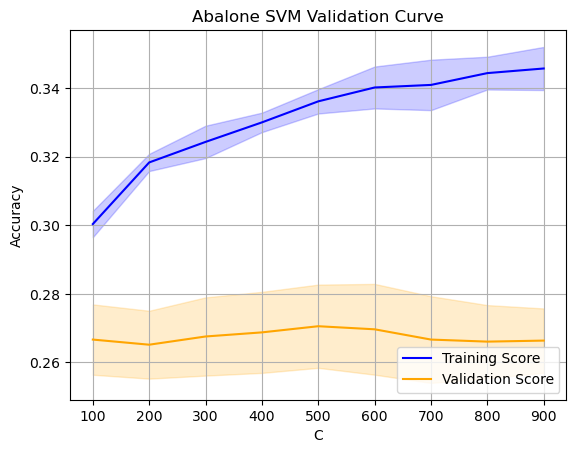

In [13]:
param_name = "C"
param_range = range(100, 1000, 100)

train_scores, valid_scores = validation_curve(
    SVC(kernel='rbf', gamma=0.01), train_s_input, train_s_target, param_name=param_name,
    param_range=param_range, cv=3
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(valid_scores, axis=1)
test_std = np.std(valid_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', label='Training Score')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.2, color='blue')

plt.plot(param_range, test_mean, color='orange', label='Validation Score')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.2, color='orange')

plt.grid()
plt.title('Abalone SVM Validation Curve', loc='center')
plt.legend(loc='lower right')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.savefig('graph\\abalone_svm_vc.png', format='png')
plt.show()

C:\Users\Minha\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


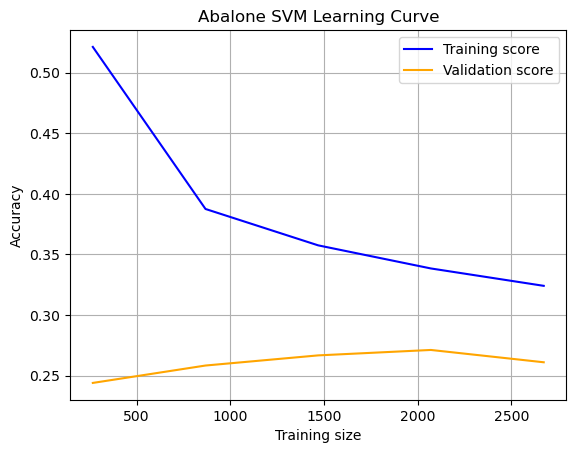

In [14]:
train_sizes, train_scores, test_scores = learning_curve(
    SVC(kernel='rbf', gamma=0.01, C=500),
    train_s_input,
    train_s_target,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.grid()
plt.title('Abalone SVM Learning Curve', loc='center')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.plot(train_sizes, train_scores_mean, color='blue', label="Training score")
plt.plot(train_sizes, test_scores_mean, color='orange', label="Validation score")
plt.legend(['Training score', 'Validation score'])
plt.savefig('graph\\abalone_svm_lc.png', format='png')
plt.show()